In [1]:
import torch
import pickle
import numpy as np
import sys
sys.path.insert(1, 'src/agent/')

/home/ark/miniconda3/envs/pvm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DEMO_FILE = "expert_demos/kitchen/kitchen_knob1_on-v3/expert_demos.pkl"
device = "cuda:0"

In [3]:
imgs, states, actions, rewards = pickle.load(open(DEMO_FILE, 'rb'))

data-format:
- imgs: (demo_id, timestep, frame_stacks * 3, 244, 244)
- state: (demo_id, timestep, state)
- actions: (demo_id, timestep, action)
- rewards: (demo_id, timestep)

In [7]:
from resnet import get_unsupervised_resnet
from vit import get_vit
# encoder, repr_dim = get_unsupervised_resnet(".", "r3m-resnet50", [], False)
encoder, repr_dim = get_vit(".", "clip-vit-b16", 224)
print(repr_dim)
# encoder.to(device)
# encoder.freeze()
# encoder.eval()

Load ckpt from ./pretrained/CLIP-ViT-B-16.pt
All keys matched successfully!
Loaded encoder from: ./pretrained/CLIP-ViT-B-16.pt
512


In [5]:
img_reprs = []
for demo in imgs:
    with torch.cuda.amp.autocast(enabled=True):
        repr = encoder(torch.as_tensor(demo, device=device))
    img_reprs.append(repr.float().cpu().numpy())
img_reprs = np.stack(img_reprs, axis=0)

In [6]:
print(img_reprs.shape, actions.shape)
n_train = int(0.9 * img_reprs.shape[0])
action_dim = actions.shape[-1]

# Datasets
X_train = img_reprs[:n_train].reshape((-1, repr_dim))
X_val = img_reprs[n_train:].reshape((-1, repr_dim))

y_train = actions[:n_train].reshape((-1, action_dim))
y_val = actions[n_train:].reshape((-1, action_dim))

(50, 50, 2048) (50, 50, 9)


In [7]:
# installed `conda install scikit-learn`
from sklearn.decomposition import PCA

pca = PCA(n_components=16)
pca.fit(X_train)

PCA(n_components=16)

In [8]:
print("Explained Variance: ", pca.explained_variance_ratio_)
print("Singular values: ", pca.singular_values_)

Explained Variance:  [0.575763   0.13352604 0.08800183 0.06641852 0.02733546 0.01899835
 0.01439553 0.01273793 0.01052288 0.00806019 0.00575793 0.0041022
 0.00368743 0.00288451 0.00253714 0.00218334]
Singular values:  [8.073135   3.887795   3.1562123  2.7419844  1.7590717  1.4664872
 1.2765392  1.2007977  1.0914092  0.9551969  0.80733496 0.681442
 0.6460736  0.57142115 0.5359108  0.49714217]


In [9]:
import matplotlib.pyplot as plt

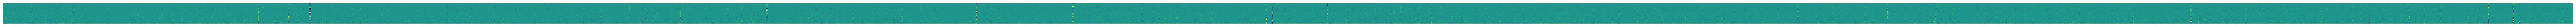

In [10]:
plt.figure(figsize=(100, 20))
plt.imshow(pca.components_ / (pca.components_.max(axis=1) - pca.components_.min(axis=1))[:, None])
plt.axis('off')
plt.show()

In [13]:
hat_x_train = pca.fit_transform(X_train)